In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from src.inference import inference, plot_img_result

In [8]:
result = inference("organic-data/test.png")

image 1/1 /home/luiz/dev/plate-detection/organic-data/test.png: 384x640 1 object, 4.9ms
Speed: 9.1ms preprocess, 4.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


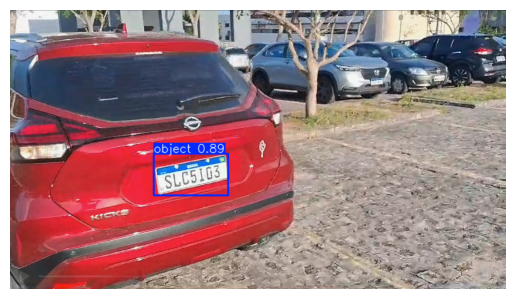

In [9]:
plot_img_result(result)

In [10]:
result.boxes.xyxy[0].tolist()


[247.61672973632812, 246.49411010742188, 375.67132568359375, 318.6572265625]

# Imagem

SLC5163 0.48379258277774595


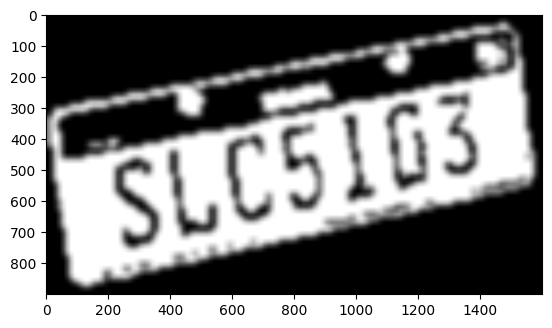

In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr

reader = easyocr.Reader(['en'],  gpu=True)
box = result.boxes.xyxy[0]

xmin, ymin, xmax, ymax = box.tolist()
cropped_image = result.orig_img[int(ymin):int(ymax), int(xmin):int(xmax)]

def process_img_to_ocr(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Binarização usando método de Otsu
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Remover ruído usando GaussianBlur
    blurred = cv2.GaussianBlur(binary, (3, 3), 0)

    # Redimensionar a imagem para melhor OCR
    width = 1600  # Defina a largura desejada
    height = int(blurred.shape[0] * (width / blurred.shape[1]))
    resized = cv2.resize(blurred, (width, height))

    # Aplicar dilatação e erosão
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(resized, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    # Ajuste de contraste
    contrast_enhanced = cv2.convertScaleAbs(eroded, alpha=1, beta=0)

    return contrast_enhanced

contrast_enhanced = process_img_to_ocr(cropped_image)

result_ocr = reader.readtext(
    contrast_enhanced,
    detail=1,
    allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ',
    text_threshold = 0.5
)
print(result_ocr[0][1], result_ocr[0][2])
plt.imshow(contrast_enhanced, cmap='gray')

# Video

In [65]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import easyocr
from time import sleep

# load a video 
cap = cv2.VideoCapture("organic-data/video_teste.mp4")
reader = easyocr.Reader(['en'])
# iterate over the frames
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # inference the frame
    result = inference(frame)

    print(f"Found {len(result.boxes.xyxy)} boxes")
    if len(result.boxes.xyxy) == 0:
        cropped_image = frame
    # iterate over the boxes and crop the image
    for box in result.boxes.xyxy:
        xmin, ymin, xmax, ymax = box.tolist()
        cropped_image = result.orig_img[int(ymin):int(ymax), int(xmin):int(xmax)]
        # get the contours of the image and paint the rectangl

        contrast_enhanced = process_img_to_ocr(cropped_image)
        
        result_ocr = reader.readtext(
            contrast_enhanced,
            detail=1,
            allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ',
            text_threshold = 0.5
        )

        for detection in result_ocr:
            (top_left, top_right, bottom_right, bottom_left) = detection[0]
            text = detection[1]
            confidence = detection[2]
            # draw the text in the frame
            cv2.putText(frame, text, (int(xmin), int(ymin)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            print("--------------------")
            print(f"Text: {text}, Confidence: {confidence}")
            print("--------------------")

        sleep(0.5)
    cv2.imshow("frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


0: 384x640 (no detections), 4.8ms
Speed: 2.6ms preprocess, 4.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
Found 0 boxes

0: 384x640 (no detections), 4.9ms
Speed: 3.3ms preprocess, 4.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Found 0 boxes

0: 384x640 (no detections), 12.9ms
Speed: 4.6ms preprocess, 12.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Found 0 boxes

0: 384x640 (no detections), 9.4ms
Speed: 2.1ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Found 0 boxes

0: 384x640 (no detections), 5.0ms
Speed: 3.4ms preprocess, 5.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
Found 0 boxes

0: 384x640 (no detections), 3.7ms
Speed: 1.6ms preprocess, 3.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Found 0 boxes

0: 384x640 (no detections), 7.2ms
Speed: 3.1ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 64

: 